In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

from matplotlib.font_manager import FontProperties

from IPython.display import display
from IPython.display import display, HTML

from scipy import stats
from scipy.stats import ttest_ind as t_test
from numpy import mean, sqrt, std

In [34]:
def stde(x):
    return np.std(x, ddof=1) / np.sqrt(len(x))

In [36]:
# MI_idx = pd.read_csv("/Users/merieldoyle/Desktop/ckMI/data/MI_idx.csv", index_col = None)

# MI_idx = MI_idx.drop(["common"], axis = 1)
# MI_idx['politics_2'] = MI_idx['politics'].apply(lambda x: 'conservative' if x > 4 else ('liberal' if x < 4 else 'centrist'))
# MI_idx = MI_idx.drop(["politics"], axis = 1)
# MI_idx = MI_idx.rename(columns={"politics_2": "politics"})
# MI_idx = MI_idx.reindex(columns=['politics'] + list(MI_idx.columns[:-1]))

# politics_table = pd.pivot_table(MI_idx, 
#                           index='condition', 
#                           columns='politics', 
#                           values=MI_idx.columns[:9], 
#                           aggfunc=('mean', 'std', stde))

# politics_table.to_csv("politics_table.csv")

### START HERE

Transformed `politics_table` manually to long form in excel

In [48]:
MI_idx = pd.read_csv('/Users/merieldoyle/Desktop/ckMI/data/politics_transformed.csv')

MI_idx.columns = MI_idx.columns.str.title()
MI_idx.iloc[:,0:3] = MI_idx.iloc[:,0:3].apply(lambda x: x.str.title())
MI_idx = MI_idx[MI_idx.Politics != 'Centrist'] # drop centrists for now

In [50]:
cols = {('Mental Illness', 'Liberal'): (0.298, 0.447, 0.690, 1.0),
        ('Mental Illness', 'Conservative'): (0.298, 0.447, 0.690, 1.0),
        ('Genes', 'Liberal'): (0.769, 0.306, 0.322, 1.0),
        ('Genes', 'Conservative'): (0.769, 0.306, 0.322, 1.0),
        ('Wrongness', 'Liberal'): (0.95, 0.6, 0.6, 1.0),
        ('Wrongness', 'Conservative'): (0.95, 0.6, 0.6, 1.0),
        ('Punishment', 'Liberal'): (0.506, 0.447, 0.701, 1.0),
        ('Punishment', 'Conservative'): (0.506, 0.447, 0.701, 1.0),
        ('Desired Change', 'Liberal'): (0.333, 0.659, 0.408, 1.0),
        ('Desired Change', 'Conservative'): (0.333, 0.659, 0.408, 1.0),
        ('Control', 'Liberal'): (0.576, 0.470, 0.376, 1.00),
        ('Control', 'Conservative'): (00.576, 0.470, 0.376, 1.0),
        ('Difficulty Changing', 'Liberal'): (0.867, 0.518, 0.322, 1.0),
        ('Difficulty Changing', 'Conservative'): (0.867, 0.518, 0.322, 1.0),
        ('Internal Distress', 'Liberal'): (0.368, 0.676, 0.678, 1.0),
        ('Internal Distress', 'Conservative'): (0.368, 0.676, 0.678, 1.0)}

def get_color(q, hue):
    key = (q, hue)
    if key in cols:
        return tuple(cols[key][:4])
    else:
        return (0.5, 0.5, 0.5, 0.5) # or some other default color
    
palette_dict = {q: {hue: get_color(q, hue) for hue in MI_idx.Politics.unique()} for q in MI_idx.Question.unique()}
        
for q, pol in zip(MI_idx.Question, MI_idx.Politics):
    color = palette_dict[q][pol]

flattened_palette = {}
for condition, palette_dict in palette_dict.items():
    for politics, color in palette_dict.items():
        key = f"{politics}_{condition}"
        flattened_palette[key] = color

In [51]:
MI_idx['hue'] = MI_idx['Politics'] + '_' + MI_idx['Question'] # create a hue column

/Users/merieldoyle/opt/anaconda3/envs/ckMIconda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/merieldoyle/opt/anaconda3/envs/ckMIconda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/merieldoyle/opt/anaconda3/envs/ckMIconda/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


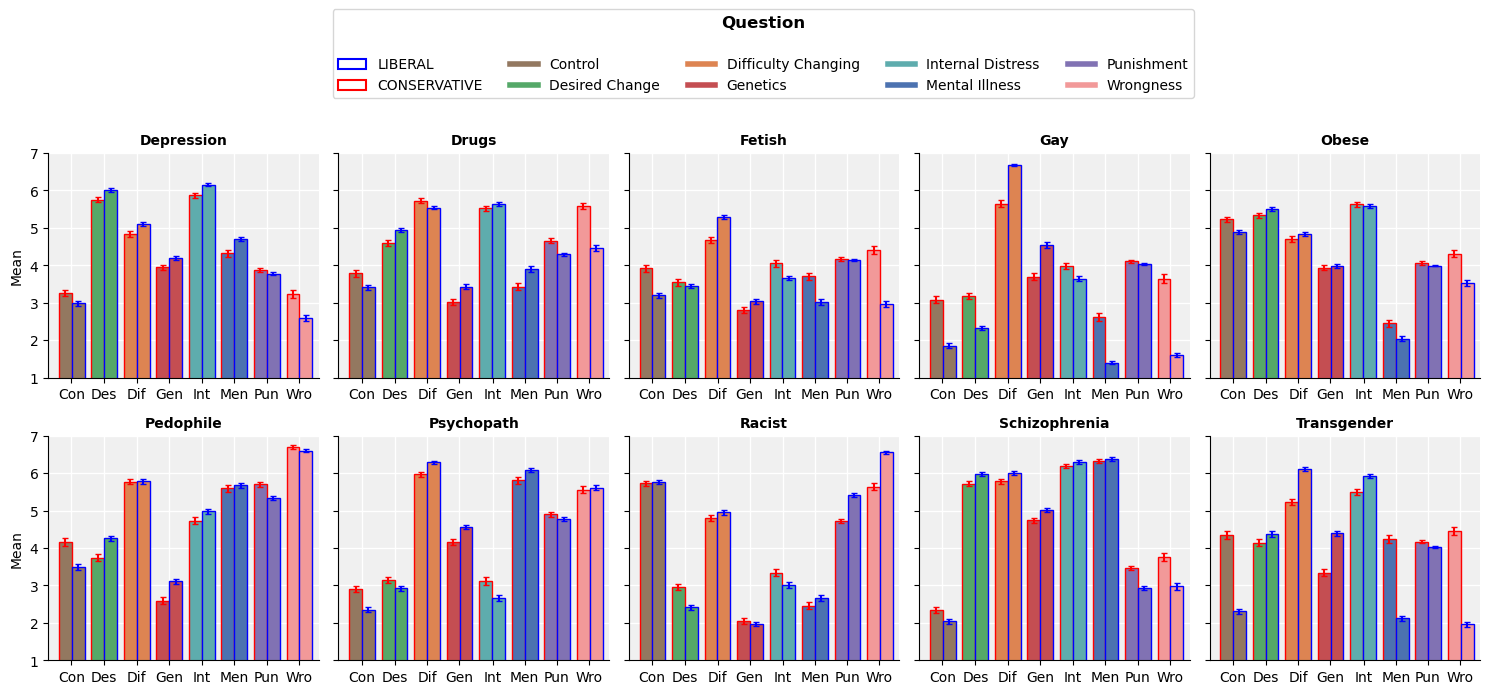

In [52]:
def custom_barplot(x, y, hue, data, width, palette, stde_col, **kwargs):
    x_categories = data[x].unique()
    hue_categories = data[hue].unique()
    
    for i, x_val in enumerate(x_categories):
        x_data = data[data[x] == x_val]
        for j, hue_val in enumerate(hue_categories):
            hue_data = x_data[x_data[hue] == hue_val]
            position = i - width / 2 + j * width / len(hue_categories)
            mean = hue_data[y].mean()
            stde_val = hue_data[stde_col].values[0] if not hue_data.empty else 0
            
            kwargs_no_color = {k: v for k, v in kwargs.items() if k != "color"}
            edge_color = "blue" if "Liberal" in hue_val else "red"
            plt.bar(position,
                    mean,
                    width=width / len(hue_categories),
                    color=palette[hue_val],
                    edgecolor=edge_color,
                    linewidth=1,
                    **kwargs_no_color)

            plt.errorbar(position, mean, yerr=stde_val, fmt='none', ecolor=edge_color, capsize=2, elinewidth=1.5)
    
    abbreviations = [q[:3] for q in x_categories] # set x-tick labels to abbreviations of each question
    
    tick_positions = [-14.1, -9.3, -4.55, 0.15, 5, 9.7, 14.4, 19.1]
    plt.xticks(tick_positions, abbreviations, ha="center")

g = sns.FacetGrid(data=MI_idx, col="Condition", col_wrap=5, sharex=False, sharey=True, height=3, aspect=1)
g.map_dataframe(custom_barplot, x="Question", y="Mean", hue="hue", width=30, palette=flattened_palette, stde_col="Stde")


# AESTHETICS

g.set(xlim=(-17.5, 22)) # set x-axis limits for each facet
g.set(ylim=(1, 7)) # set y-axis limits for each facet
g.set_xlabels('')  # remove x-axis label
g.set_titles(fontweight='bold', col_template="{col_name}") # title

for ax in g.axes.flat:
    ax.set_facecolor('#F0F0F0')  # set background color
    ax.yaxis.grid(True, linestyle='-', linewidth=1, alpha=1, color = 'white')  # faint horizontal gridlines
    ax.xaxis.grid(True, linestyle='-', linewidth=1, alpha=1, color = 'white')  # faint vertical gridlines
    ax.set_axisbelow(True)  # put gridlines below bar plots

unique_colors = list(set(flattened_palette.values())) # flattened_palette = dictionary mapping label names to colors

unique_colors = [(0.576, 0.47, 0.376, 1.0), # control / brown
                 (0.333, 0.659, 0.408, 1.0), # desired change / green
                 (0.867, 0.518, 0.322, 1.0), # difficulty changing / orange
                 (0.769, 0.306, 0.322, 1.0), # genes / red
                 (0.368, 0.676, 0.678, 1.0), # internal distress / teal
                 (0.298, 0.447, 0.69, 1.0), # mental illness / blue
                 (0.506, 0.447, 0.701, 1.0), # punishment / purple
                 (0.95, 0.6, 0.6, 1.0)] # wrongness / pink

custom_labels = ["Control",
                 "Desired Change",
                 "Difficulty Changing",
                 "Genetics",
                 "Internal Distress",
                 "Mental Illness",
                 "Punishment",  
                 "Wrongness"] 

outline_handles = [Rectangle((0, 0), 0.5, 0.25, facecolor='white', edgecolor='blue', lw=1.5, label='LIBERAL'),
                   Rectangle((0, 0), 0.5, 0.25, facecolor='white', edgecolor='red', lw=1.5, label='CONSERVATIVE')]

legend_elements = outline_handles + [Line2D([0], [0], 
                                    color=unique_colors[i], 
                                    lw=4, 
                                    label=custom_labels[i]) for i in range(len(unique_colors))]

spacer = Line2D([0], [0], color='none', lw=0, label='')
legend_elements.insert(0, spacer)
legend_elements.insert(3, spacer)
legend_elements.insert(6, spacer)
legend_elements.insert(9, spacer)
legend_elements.insert(12, spacer)

legend = plt.legend(handles=legend_elements, # add legend to facet grid
                    ncol=5, 
                    bbox_to_anchor=(-1.65, 2.7), 
                    loc='center', 
                    title='Question', 
                    title_fontsize=12)

legend.get_title().set_fontweight('bold')  # bold legend title

plt.show()

save_path = "/Users/merieldoyle/Desktop/NEW_descriptives_ideology.png"
g.savefig(save_path, dpi=300)

MEAN, SD, T-TEST

In [78]:
MI_idx = pd.read_csv("/Users/merieldoyle/Desktop/ckMI/data/MI_idx.csv", index_col = None)

MI_idx['politics_2'] = MI_idx['politics'].apply(lambda x: 'conservative' if x > 4 else ('liberal' if x < 4 else 'centrist'))
MI_idx = MI_idx.drop(["politics"], axis = 1)
MI_idx = MI_idx.rename(columns={"politics_2": "politics"})
MI_idx = MI_idx.reindex(columns=['politics'] + list(MI_idx.columns[:-1]))
MI_idx = MI_idx[MI_idx.politics != 'centrist'] # drop centrists
MI_idx = MI_idx.drop(["common"], axis = 1) # drop common

wide_pol = pd.pivot_table(MI_idx, 
                          index=['condition', 'politics'], 
                          values=MI_idx.columns[2:10], 
                          aggfunc=('mean', 'std'))

wide_pol = wide_pol.rename(columns={'mean': 'M'}) 
wide_pol = wide_pol.rename(columns={'std': 'SD'}) 

wide_pol = wide_pol.applymap(lambda x: "{:.2f}".format(x))

wide_pol

control       desired change        \
                                 M    SD              M    SD   
condition     politics                                          
depression    conservative    3.26  1.54           5.75  1.36   
              liberal         2.98  1.59           6.00  1.31   
drugs         conservative    3.78  1.95           4.61  1.57   
              liberal         3.41  1.53           4.94  1.52   
fetish        conservative    3.91  1.73           3.54  1.64   
              liberal         3.20  1.65           3.44  1.47   
gay           conservative    3.08  1.85           3.19  1.60   
              liberal         1.85  1.48           2.32  1.39   
obese         conservative    5.23  1.26           5.33  1.44   
              liberal         4.90  1.29           5.50  1.30   
pedophile     conservative    4.15  1.91           3.74  1.70   
              liberal         3.49  1.90           4.25  1.69   
psychopath    conservative    2.91  1.66           3.15  1.71   
              liberal         2.35  1.53           2.92  1.68   
racist        conservative    5.72  1.39           2.95  1.55   
              liberal         5.77  1.44           2.41  1.41   
schizophrenia conservative    2.34  1.49           5.72  1.34   
              liberal         2.04  1.38           5.98  1.33   
transgender   conservative    4.35  1.96           4.14  1.83   
              liberal         2.31  1.69           4.38  2.01   

                           difficulty changing       genes        \
                                             M    SD     M    SD   
condition     politics                                             
depression    conservative                4.83  1.43  3.94  1.37   
              liberal                     5.10  1.32  4.18  1.35   
drugs         conservative                5.73  1.18  3.01  1.58   
              liberal                     5.54  1.23  3.43  1.50   
fetish        conservative                4.67  1.60  2.80  1.50   
              liberal                     5.28  1.40  3.03  1.53   
gay           conservative                5.65  1.60  3.69  1.84   
              liberal                     6.68  0.87  4.54  1.95   
obese         conservative                4.70  1.46  3.93  1.29   
              liberal                     4.84  1.47  3.98  1.21   
pedophile     conservative                5.77  1.41  2.59  1.65   
              liberal                     5.78  1.42  3.11  1.61   
psychopath    conservative                5.96  1.24  4.15  1.55   
              liberal                     6.29  1.14  4.57  1.44   
racist        conservative                4.80  1.54  2.04  1.51   
              liberal                     4.95  1.49  1.97  1.49   
schizophrenia conservative                5.78  1.23  4.74  1.34   
              liberal                     5.99  1.25  5.01  1.30   
transgender   conservative                5.22  1.59  3.34  1.86   
              liberal                     6.10  1.35  4.39  1.82   

                           internal distress       mental illness        \
                                           M    SD              M    SD   
condition     politics                                                    
depression    conservative              5.87  1.20           4.31  1.57   
              liberal                   6.15  1.12           4.71  1.49   
drugs         conservative              5.52  1.36           3.43  1.95   
              liberal                   5.63  1.38           3.90  1.75   
fetish        conservative              4.05  1.69           3.70  1.94   
              liberal                   3.66  1.52           3.02  1.73   
gay           conservative              3.99  1.60           2.62  1.85   
              liberal                   3.64  1.71           1.39  1.07   
obese         conservative              5.63  1.23           2.45  1.66   
              liberal                   5.59  1.21           2.04 

In [77]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

def t_test(group1, group2):
    t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy="omit", equal_var=False)
    return t_stat, p_val

def calc_stats(df, group_col='politics', condition=None, value_cols=None):
        
    results_df = pd.DataFrame(columns=['t-statistic', 'p-value', "Cohen's d"], index=pd.MultiIndex.from_product([condition, value_cols]))

    for row in condition:
        for col in value_cols:

            group1 = df[(df[group_col] == 'liberal') & (df['condition'] == row)][col]
            group2 = df[(df[group_col] == 'conservative') & (df['condition'] == row)][col]
            
            t_stat, p_val = t_test(group1, group2) # , nan_policy="omit")
            d = cohen_d(group1, group2)
            
            if p_val < 0.001:
                p_val = "<.001"
            else:
                p_val = "{:.3f}".format(p_val)

            results_df.loc[(row, col), 't-statistic'] = "{:.2f}".format(t_stat)
            results_df.loc[(row, col), 'p-value'] = p_val
            results_df.loc[(row, col), "Cohen's d"] = "{:.2f}".format(d)

    return results_df

condition = MI_idx['condition'].unique()
value_cols = MI_idx.columns[2:10].tolist()
results_df = calc_stats(MI_idx, condition=condition, value_cols=value_cols)


pd.set_option('display.max_rows', None)

# pd.reset_option('display.max_rows') # reset max rows and columns
# display(HTML("<style>div.output_scroll { height: 1000px; }</style>")) # restart kernel to revert to default settings

results_df

t-statistic p-value Cohen's d
pedophile     mental illness             0.49   0.624      0.05
              difficulty changing        0.06   0.956      0.01
              desired change             2.86   0.005      0.30
              genes                      3.01   0.003      0.32
              punishment                -2.65   0.009     -0.28
              control                   -3.28   0.001     -0.35
              wrongness                 -1.00   0.318     -0.11
              internal distress          1.41   0.161      0.15
drugs         mental illness             2.37   0.018      0.26
              difficulty changing       -1.47   0.144     -0.15
              desired change             2.03   0.044      0.22
              genes                      2.59   0.010      0.28
              punishment                -3.01   0.003     -0.32
              control                   -1.94   0.054     -0.22
              wrongness                 -6.40   <.001     -0.64
              internal distress          0.76   0.450      0.08
psychopath    mental illness             1.84   0.067      0.19
              difficulty changing        2.62   0.009      0.28
              desired change            -1.28   0.202     -0.13
              genes                      2.65   0.009      0.28
              punishment                -1.03   0.303     -0.11
              control                   -3.37   <.001     -0.35
              wrongness                  0.26   0.792      0.03
              internal distress         -2.30   0.022     -0.24
gay           mental illness            -7.45   <.001     -0.86
              difficulty changing        7.35   <.001      0.86
              desired change            -5.50   <.001     -0.59
              genes                      4.33   <.001      0.44
              punishment                -1.04   0.301     -0.11
              control                   -6.97   <.001     -0.76
              wrongness                -10.22   <.001     -1.16
              internal distress         -2.04   0.042     -0.21
fetish        mental illness            -3.02   0.003     -0.38
              difficulty changing        3.27   0.001      0.41
              desired change            -0.52   0.605     -0.07
              genes                      1.26   0.210      0.15
              punishment                -0.29   0.776     -0.04
              control                   -3.44   <.001     -0.43
              wrongness                 -5.93   <.001     -0.73
              internal distress         -1.96   0.051     -0.25
racist        mental illness             1.10   0.270      0.11
              difficulty changing        0.97   0.335      0.10
              desired change            -3.49   <.001     -0.37
              genes                     -0.47   0.641     -0.05
              punishment                 5.74   <.001      0.58
              control                    0.30   0.767      0.03
              wrongness                  5.81   <.001      0.68
              internal distress         -1.78   0.075     -0.18
transgender   mental illness           -10.78   <.001     -1.19
              difficulty changing        5.71   <.001      0.62
              desired change             1.26   0.207      0.13
              genes                      5.50   <.001      0.57
              punishment                -1.97   0.050     -0.21
              control                  -10.62   <.001     -1.14
              wrongness                -12.56   <.001     -1.40
              internal distress          2.69   0.008      0.29
obese         mental illness            -2.79   0.006     -0.26
              difficulty changing        1.06   0.290      0.10
              desired change             1.35   0.178      0.13
              genes                      0.46   0.649      0.04
              punishment                -1.07   0.284     -0.11
              control                   -2.83   0.005     -0.26
  